In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import scipy.stats as stats
import seaborn as sns

In [3]:
#Importing original dataset via CSV (https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset)
import pandas as pd
def load_dataset(csv):
  df = pd.read_csv(csv)
  return df
csv = 'Datasets/train_online_shoppers_intention.csv'
df = load_dataset(csv)

#Removing Outliers of excessively high session duration 
def remove_outliers_iqr(df):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df['SessionDuration'].quantile(0.25)
    Q3 = df['SessionDuration'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    df_no_outliers = df[(df <= upper_bound)].dropna()
    return df_no_outliers
# Remove outliers from the dataset
sessions = remove_outliers_iqr(df)

#Dropping values that are binary as un important for clustering
sessions.drop('VisitorType_New_Visitor', axis=1, inplace=True)
sessions.drop('VisitorType_Returning_Visitor', axis=1, inplace=True)
sessions.drop('VisitorType_Other', axis=1, inplace=True)
sessions.drop('SpecialDay', axis=1, inplace=True)
sessions.drop('Weekend', axis=1, inplace=True)
#print((sessions['Revenue']==1).sum())

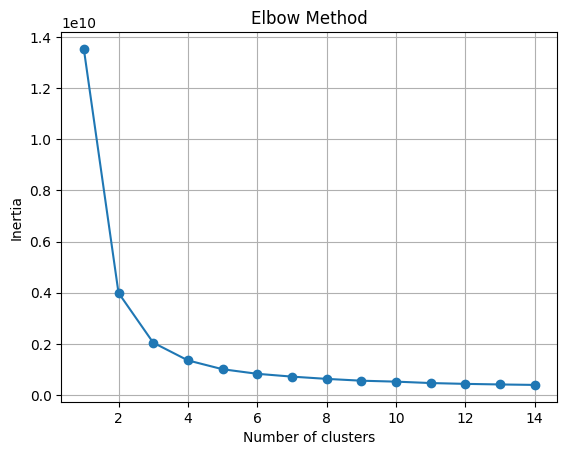

In [4]:
#How many K Means we should use with Elbow Method
from sklearn.cluster import KMeans
def elbow_method(data, max_k):
  inertias = []
  for i in range(1, max_k):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)
  
  plt.plot(range(1, max_k), inertias, 'o-')
  plt.title('Elbow Method')
  plt.xlabel('Number of clusters')
  plt.ylabel('Inertia')
  plt.grid(True)
  plt.show()

elbow_method(sessions, 15)

In [6]:
# Performing KMeans clustering
from sklearn.cluster import KMeans
import pandas as pd
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(sessions)

sk_centroids = kmeans.cluster_centers_  # Cluster centroids
sk_labels = kmeans.labels_  # Cluster labels for each data point

#Adding clusters to sessions
sessions['Cluster'] = sk_labels

# Display centroids and sample data points
centroid_df = pd.DataFrame(sk_centroids, columns=sessions.columns[:])  # Adjust for the added 'Cluster' column
print("Centroids Overview:\n", centroid_df)


Centroids Overview:
    Administrative  Administrative_Duration  Informational  \
0        2.538000                85.560483       0.463333   
1        0.775579                18.062671       0.089525   
2        3.934037               161.715080       0.894459   
3        3.202346               125.622522       0.691105   
4        1.883074                58.143623       0.324847   
5        4.162222               126.288759       1.062222   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0               27.135253       28.769333               951.253499   
1                2.476896        6.330085               110.573311   
2               74.405136       52.110818              2139.249511   
3               44.720849       39.174976              1491.956847   
4               15.845381       17.757661               487.023851   
5               63.205475       72.100000              3003.590570   

   BounceRates  ExitRates  PageValues     Month  OperatingSy

In [7]:
#USING ANOVA to see statistical difference between the means of each feature across the clusters
results = {}
num_clusters = len(set(sk_labels))  # Get the number of unique clusters in `sk_labels`
for feature in sessions.columns:
    if feature != 'labels':
        feature_data = [sessions[sk_labels == i][feature] for i in range(num_clusters) if len(sessions[sk_labels == i]) > 0]
        if all(len(data) > 1 for data in feature_data) and len(feature_data) > 1:
            # Perform ANOVA for the current feature across all centroids (clusters)
            stat, p_value = stats.f_oneway(*feature_data)
            # Store the p-value in the results dictionary
            results[feature] = p_value
        else:
            print(f"Not enough data for ANOVA in feature '{feature}'")

# Initialize a dictionary to store only the significant features
significant_features = {feature: p_value for feature, p_value in results.items() if p_value < 0.05}

# Print the significant features
print("Significant Features:", significant_features)

Significant Features: {'Administrative': 3.76229258e-315, 'Administrative_Duration': 4.4756672199502747e-218, 'Informational': 3.537456795200883e-166, 'Informational_Duration': 4.097641819957128e-98, 'ProductRelated': 0.0, 'ProductRelated_Duration': 0.0, 'BounceRates': 0.0, 'ExitRates': 0.0, 'PageValues': 1.3436416554744226e-60, 'Month': 1.9038807798209196e-20, 'TrafficType': 1.7289293832306905e-05, 'Revenue': 3.586278563268658e-83, 'SessionDuration': 0.0, 'TotalPagesViewed': 0.0, 'Cluster': 0.0}


C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:531: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


Cluster 0 Summary:
       Administrative  Administrative_Duration  Informational  \
count     1500.000000              1500.000000    1500.000000   
mean         2.538667                85.586706       0.462667   
std          3.135239               150.380964       1.155925   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          1.000000                29.250000       0.000000   
75%          4.000000               111.051250       0.000000   
max         18.000000              1764.000000      16.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count             1500.000000     1500.000000              1500.000000   
mean                27.123476       28.760667               950.538824   
std                100.209110       15.262897               178.235093   
min                  0.000000        1.000000                45.700000   
25%                  0.00

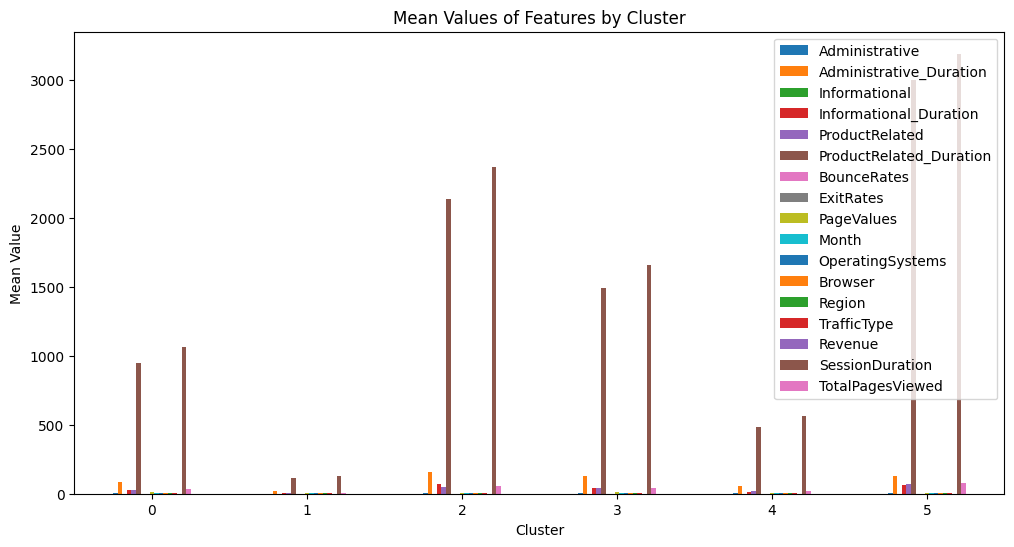

In [8]:
#Grouping the data by clusters for visualization
import matplotlib.pyplot as plt
grouped = sessions.groupby('Cluster')

# Calculate descriptive statistics for each cluster
cluster_summary = grouped.agg(['mean', 'median', 'std', 'min', 'max'])

# Display the summary statistics for each cluster
for cluster_id, cluster_data in grouped:
    print(f"Cluster {cluster_id} Summary:")
    print(cluster_data.describe())  # Summary of each cluster
    print("\n")

# Plot the mean value of each feature for each cluster
cluster_means = grouped.mean()
cluster_means.plot(kind='bar', figsize=(12, 6), title="Mean Values of Features by Cluster")
plt.ylabel("Mean Value")
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.show()


In [ ]:
#Used to identify individual sessions in the columns as an overview
features=['Revenue', 'SessionDuration', 'TotalPagesViewed', 'BounceRates', 'ExitRates', 'PageValues', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend', 'VisitorType_New_Visitor', 'VisitorType_Other', 'VisitorType_Returning_Visitor']
#View the values in each Cluster if meaningful*
print(sessions.loc[sessions['Cluster'] == 5, 'PageValues'])

print("\nSample Data Points from Each Cluster:")
for cluster_id in centroid_df.index:
    print(f"\nCluster {cluster_id}:\n", sessions[sessions['Cluster'] == cluster_id].head())

In [10]:
#Seeing how much revenue is attributed to each cluster
print("Cluster 0, % values generated revenue:",sessions[(sessions['Cluster']==0)&(sessions['Revenue']==1)].shape[0]/(sessions['Cluster']==0).sum())
print("Cluster 1, % values generated revenue:",sessions[(sessions['Cluster']==1)&(sessions['Revenue']==1)].shape[0]/(sessions['Cluster']==1).sum())
print("Cluster 2, % values generated revenue:",sessions[(sessions['Cluster']==2)&(sessions['Revenue']==1)].shape[0]/(sessions['Cluster']==2).sum())
print("Cluster 3, % values generated revenue:",sessions[(sessions['Cluster']==3)&(sessions['Revenue']==1)].shape[0]/(sessions['Cluster']==3).sum())
print("Cluster 4, % values generated revenue:",sessions[(sessions['Cluster']==4)&(sessions['Revenue']==1)].shape[0]/(sessions['Cluster']==4).sum())
print("Cluster 5, % values generated revenue:",sessions[(sessions['Cluster']==5)&(sessions['Revenue']==1)].shape[0]/(sessions['Cluster']==5).sum())
#print("Cluster 6, % values generated revenue:",sessions[(sessions['Cluster']==6)&(sessions['Revenue']==1)].shape[0]/(sessions['Cluster']==6).sum())
#print("Cluster 7, % values generated revenue:",sessions[(sessions['Cluster']==7)&(sessions['Revenue']==1)].shape[0]/(sessions['Cluster']==7).sum())

Cluster 0, % values generated revenue: 0.20666666666666667
Cluster 1, % values generated revenue: 0.05210237659963437
Cluster 2, % values generated revenue: 0.23381770145310435
Cluster 3, % values generated revenue: 0.19707317073170733
Cluster 4, % values generated revenue: 0.16124469589816123
Cluster 5, % values generated revenue: 0.24168514412416853
